In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from metrics import evaluate_model


In [2]:
football_data_odds = pd.read_csv('data/football_data/historical_odds.csv',low_memory=False)

football_data_odds['home_win']=np.where(football_data_odds['FTHG']>football_data_odds['FTAG'],1,0)
football_data_odds['draw']=np.where(football_data_odds['FTHG']==football_data_odds['FTAG'],1,0)
football_data_odds['away_win']=np.where(football_data_odds['FTHG']<football_data_odds['FTAG'],1,0)
football_data_odds['result']=np.where(football_data_odds['home_win']==1,0,np.where(football_data_odds['draw']==1,1,2))
football_data_odds['Date_formatted'] = pd.to_datetime(football_data_odds['Date'],format='mixed')

number_of_games_per_day = football_data_odds.groupby('Date_formatted').count().iloc[:,0].to_frame()
number_of_games_per_day.columns = ['number_of_games_on_this_day']

football_data_odds = pd.merge(football_data_odds,number_of_games_per_day,how='left',left_on='Date_formatted',right_index=True)

football_data_odds.sort_values(by=['Date_formatted','Div','HomeTeam'],inplace=True)
football_data_odds.reset_index(inplace=True)




def create_implied_prob_from_odds(df,odds_columns):
    implied_probs_df = 1/df[odds_columns]
    implied_odds_column_names = [f'{x}_implied_prob' for x in odds_columns]
    implied_probs_df.columns = implied_odds_column_names

    return implied_probs_df

def get_overround(df,implied_probs_columns):
    return df[implied_probs_columns].sum()

def add_1x2_favorite_columns(df,book_name):
    df_copy = df.copy()
    df_copy[f'{book_name}_favorite_selection'] = np.argmin(football_data_odds[[f'{book_name}H',f'{book_name}D',f'{book_name}A']],axis=1)


    df_copy[f'{book_name}_favorite_odds'] = np.min(df_copy[[f'{book_name}H',f'{book_name}D',f'{book_name}A']],axis=1)

    df_copy[f'{book_name}_favorite_implied_prob'] = np.max(df_copy[[f'{book_name}H_implied_prob',f'{book_name}D_implied_prob',f'{book_name}A_implied_prob']],axis=1)
    df_copy[f'{book_name}_favorite_stripped_prob'] = np.max(df_copy[[f'{book_name}H_stripped_prob',f'{book_name}D_stripped_prob',f'{book_name}A_stripped_prob']],axis=1)

    df_copy[f'{book_name}_favorite_result'] = np.where(df_copy[f'{book_name}_favorite_selection']==0,df_copy['home_win'],
                                                        np.where(df_copy[f'{book_name}_favorite_selection']==1,df_copy['draw'],
                                                        np.where(df_copy[f'{book_name}_favorite_selection']==2,df_copy['away_win'],0))
                                                        )
    
    return df_copy

def add_1x2_underdog_columns(df,book_name):
    df_copy = df.copy()
    df_copy[f'{book_name}_underdog_selection'] = np.argmax(football_data_odds[[f'{book_name}H',f'{book_name}D',f'{book_name}A']],axis=1)

    df_copy[f'{book_name}_underdog_implied_prob'] = np.min(df_copy[[f'{book_name}H_implied_prob',f'{book_name}D_implied_prob',f'{book_name}A_implied_prob']],axis=1)
    df_copy[f'{book_name}_underdog_stripped_prob'] = np.min(df_copy[[f'{book_name}H_stripped_prob',f'{book_name}D_stripped_prob',f'{book_name}A_stripped_prob']],axis=1)

    df_copy[f'{book_name}_underdog_result'] = np.where(df_copy[f'{book_name}_underdog_selection']==0,df_copy['home_win'],
                                                        np.where(df_copy[f'{book_name}_underdog_selection']==1,df_copy['draw'],
                                                        np.where(df_copy[f'{book_name}_underdog_selection']==2,df_copy['away_win'],0))
                                                        )
    
    return df_copy


def prepreocess_odds(df,book_name,market_name='1X2'):
    df_copy = df.copy()

    # get implied probs columns
    implied_probs_df = create_implied_prob_from_odds(df,[f'{book_name}H',f'{book_name}D',f'{book_name}A'])
    df_copy[f'{book_name}_{market_name}_overround']=implied_probs_df.sum(axis=1)
    stripped_probs_df = implied_probs_df.div(df_copy[f'{book_name}_{market_name}_overround'],axis=0)
    stripped_probs_df.columns = [x.replace('implied','stripped') for x in stripped_probs_df.columns]

    df_copy = pd.concat([df_copy,implied_probs_df,stripped_probs_df],axis=1)

    df_copy = add_1x2_favorite_columns(df_copy,book_name=book_name)
    df_copy = add_1x2_underdog_columns(df_copy,book_name=book_name)

    return df_copy


odds_subset = ['PSH','PSCH','B365H']
football_data_odds['B365H'] = football_data_odds['B365H'].replace(0.0,np.nan)
football_data_odds.dropna(subset=odds_subset,inplace=True)

football_data_odds = prepreocess_odds(football_data_odds,book_name='PS')
football_data_odds = prepreocess_odds(football_data_odds,book_name='PSC')
football_data_odds = prepreocess_odds(football_data_odds,book_name='BFE')
football_data_odds = prepreocess_odds(football_data_odds,book_name='BFEC')
football_data_odds = prepreocess_odds(football_data_odds,book_name='B365')
# football_data_odds = prepreocess_odds(football_data_odds,book_name='B365C')

In [3]:
football_data_odds

,index,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,B365A_stripped_prob,B365_favorite_selection,B365_favorite_odds,B365_favorite_implied_prob,B365_favorite_stripped_prob,B365_favorite_result,B365_underdog_selection,B365_underdog_implied_prob,B365_underdog_stripped_prob,B365_underdog_result
0,24060,SC0,01/08/15,Celtic,Ross County,2.0,0.0,H,2.0,0.0,...,0.062643,0,1.17,0.854701,0.803121,1,2,0.066667,0.062643,0
1,24061,SC0,01/08/15,Hamilton,Partick,0.0,0.0,D,0.0,0.0,...,0.375255,2,2.50,0.400000,0.375255,0,1,0.285714,0.268039,1
2,24062,SC0,01/08/15,Inverness C,Motherwell,0.0,1.0,A,0.0,1.0,...,0.188331,0,1.67,0.598802,0.563865,0,2,0.200000,0.188331,1
3,24063,SC0,01/08/15,Kilmarnock,Dundee,0.0,4.0,A,0.0,2.0,...,0.347933,0,2.50,0.400000,0.375767,0,1,0.294118,0.276300,0
4,7697,D1,01/11/15,Hamburg,Hannover,1.0,2.0,A,1.0,0.0,...,0.237410,0,2.00,0.500000,0.474820,0,2,0.250000,0.237410,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31803,7521,SP1,12/04/2025,Getafe,Las Palmas,1.0,3.0,A,1.0,0.0,...,0.172131,0,1.75,0.571429,0.540984,0,2,0.181818,0.172131,1
31804,7523,SP1,12/04/2025,Leganes,Barcelona,0.0,1.0,A,0.0,0.0,...,0.730136,2,1.30,0.769231,0.730136,1,0,0.117647,0.111668,0
31805,7520,SP1,12/04/2025,Sociedad,Mallorca,0.0,2.0,A,0.0,1.0,...,0.173596,0,1.75,0.571429,0.545587,0,2,0.181818,0.173596,1
31806,14440,I1,12/05/2025,Atalanta,Roma,2.0,1.0,H,1.0,1.0,...,0.252223,0,1.95,0.512821,0.485044,1,2,0.266667,0.252223,0


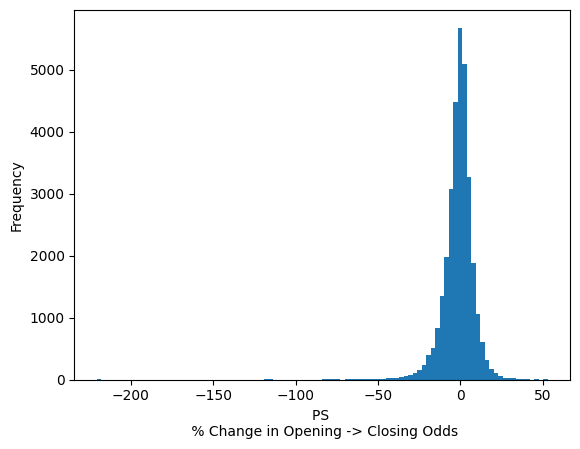

In [4]:
def plot_opening_and_closing_differences(df_with_historical_odds,book_name=''):
    diff = (100*(df_with_historical_odds[f'{book_name}H']-df_with_historical_odds[f'{book_name}CH'])/df_with_historical_odds[f'{book_name}H'])
    diff.plot.hist(bins=100)
    plt.xlabel(f'{book_name} \n % Change in Opening -> Closing Odds')
    return diff

diff = plot_opening_and_closing_differences(football_data_odds,'PS')

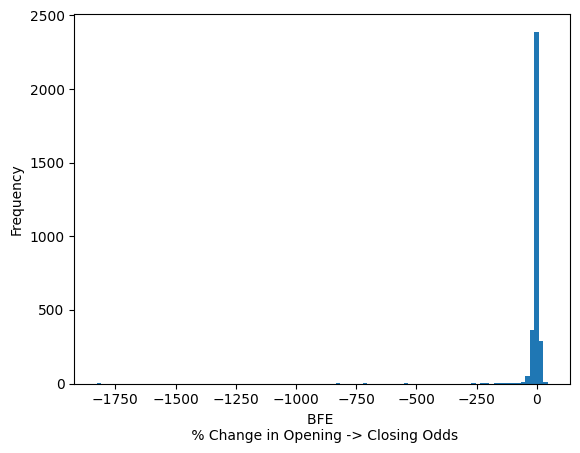

In [5]:
diff = plot_opening_and_closing_differences(football_data_odds,'BFE')


--- Performance Metrics on Test Set ---
brier_score_loss: 0.20986740925977765
log_loss: 0.6064700646016684
median_calibration_error_metric: 0.022752977849869904
total_calibration_error_metric: 2.0263854588441452
mean_calibration_error_metric: 0.02597930075441212
Accuracy: 0.6514

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.72      0.61      0.66     17740
     Class 1       0.59      0.70      0.64     13969

    accuracy                           0.65     31709
   macro avg       0.65      0.66      0.65     31709
weighted avg       0.66      0.65      0.65     31709



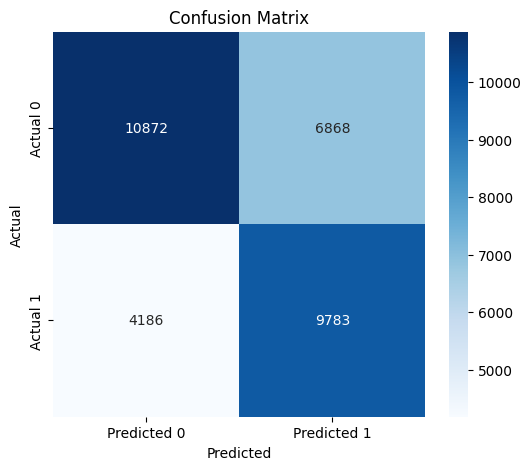

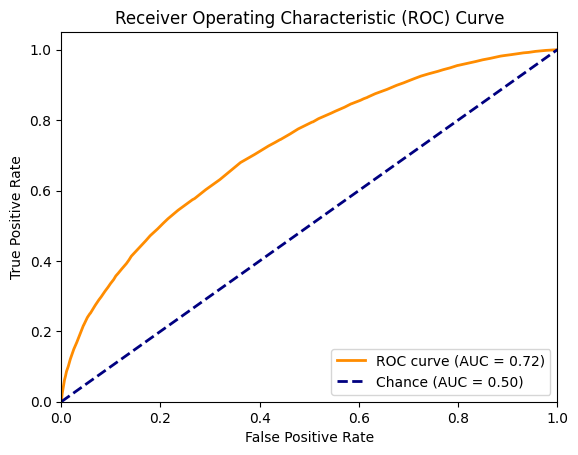


--- Assessing Model Calibration ---


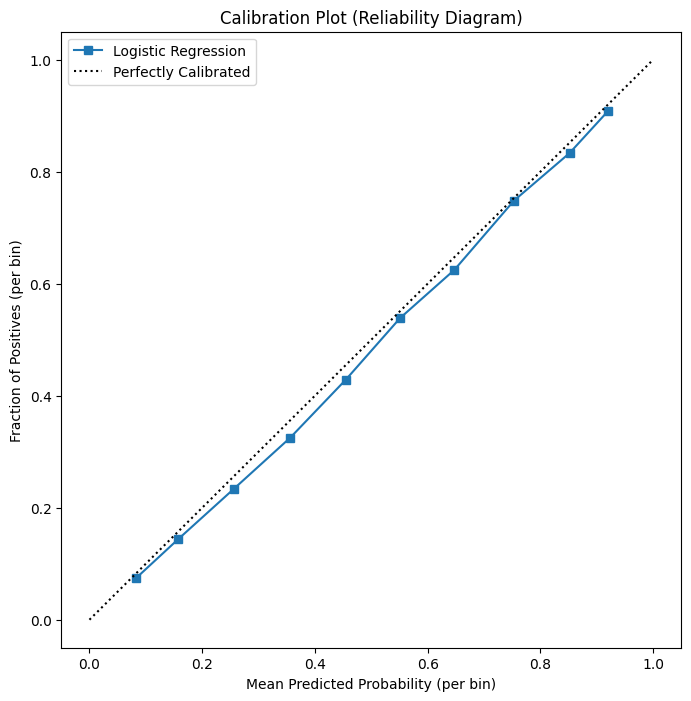

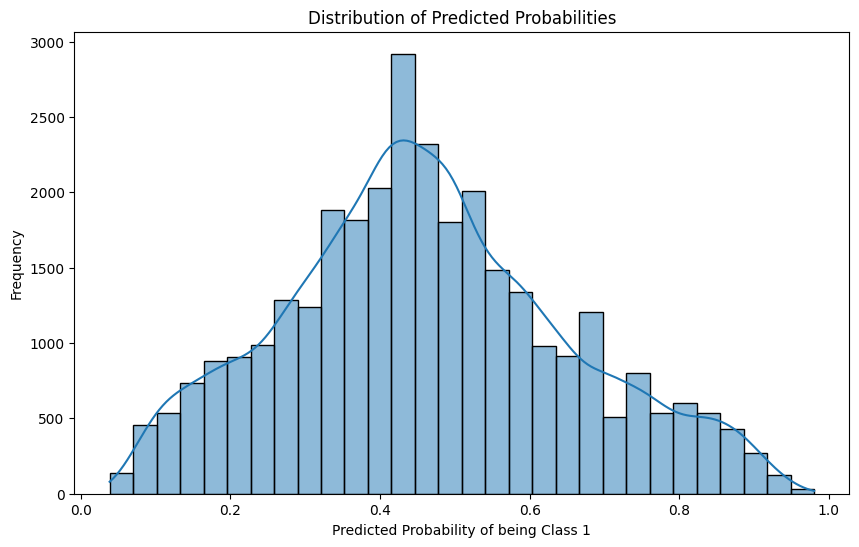

In [6]:
evaluate_model(y_true=football_data_odds['home_win'],y_pred_proba=football_data_odds['B365H_implied_prob'])

In [7]:
# evaluate_model(y_true=football_data_odds['home_win'],y_pred_proba=football_data_odds['B365CH_stripped_prob'])


--- Performance Metrics on Test Set ---
brier_score_loss: 0.20947996654795978
log_loss: 0.6055142814755141
median_calibration_error_metric: 0.018320468760474648
total_calibration_error_metric: 2.365983103575403
mean_calibration_error_metric: 0.023659831035754027
Accuracy: 0.6548

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.71      0.65      0.68     17740
     Class 1       0.60      0.67      0.63     13969

    accuracy                           0.65     31709
   macro avg       0.65      0.66      0.65     31709
weighted avg       0.66      0.65      0.66     31709



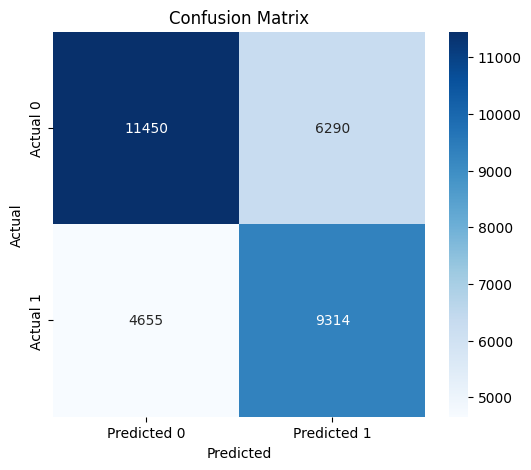

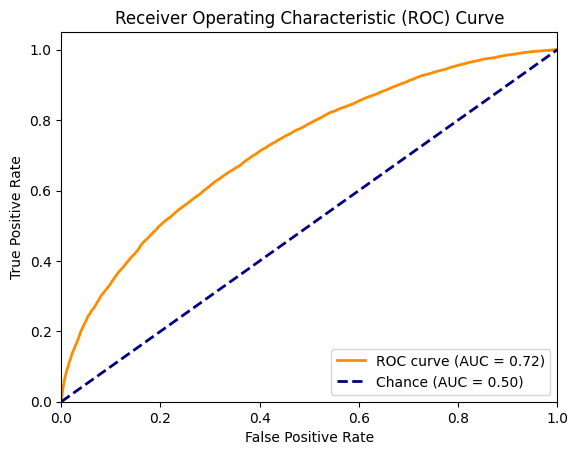


--- Assessing Model Calibration ---


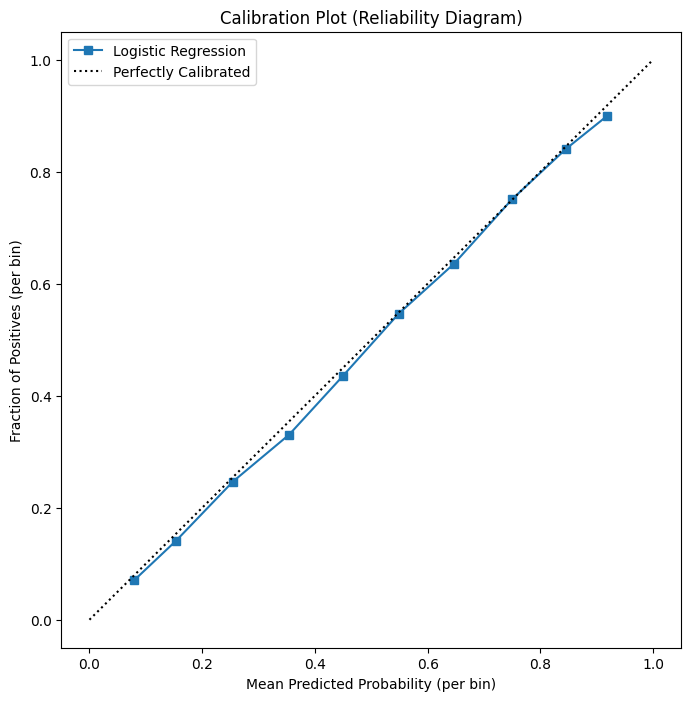

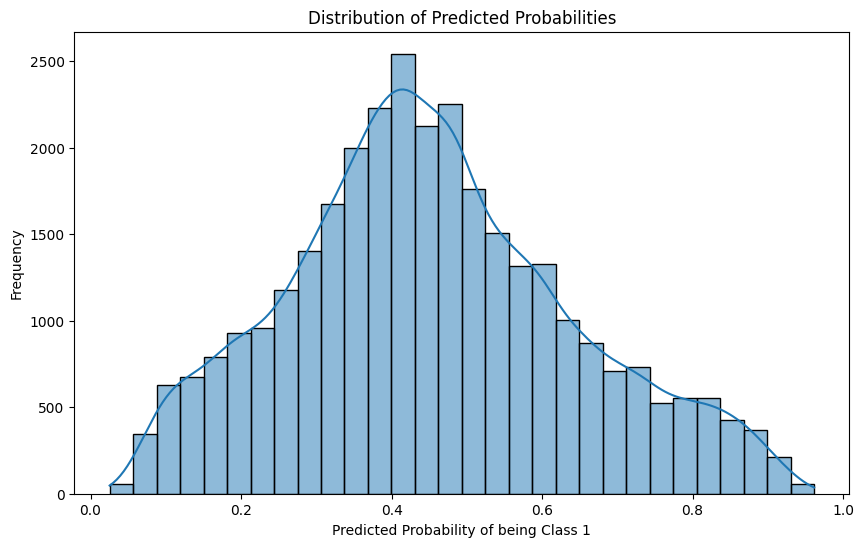

In [8]:
evaluate_model(y_true=football_data_odds['home_win'],y_pred_proba=football_data_odds['PSH_implied_prob'])

In [9]:
c = 0.1
football_data_odds['cheat'] = np.where(football_data_odds['home_win']==1,football_data_odds['PSCH_stripped_prob']*(1+c),football_data_odds['PSCH_stripped_prob']*(1-c))
football_data_odds['cheat']=np.minimum(football_data_odds['cheat'],1)


--- Performance Metrics on Test Set ---
brier_score_loss: 0.172924982127216
log_loss: 0.5212259442297736
median_calibration_error_metric: 0.08871325638775493
total_calibration_error_metric: 8.529326034964749
mean_calibration_error_metric: 0.08529326034964749
Accuracy: 0.7571

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.79      0.77      0.78     17740
     Class 1       0.72      0.74      0.73     13969

    accuracy                           0.76     31709
   macro avg       0.75      0.75      0.75     31709
weighted avg       0.76      0.76      0.76     31709



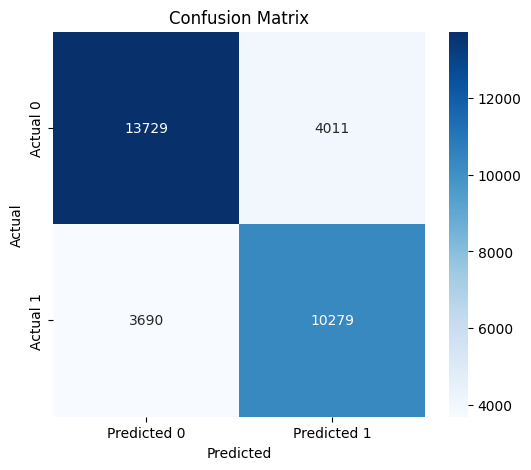

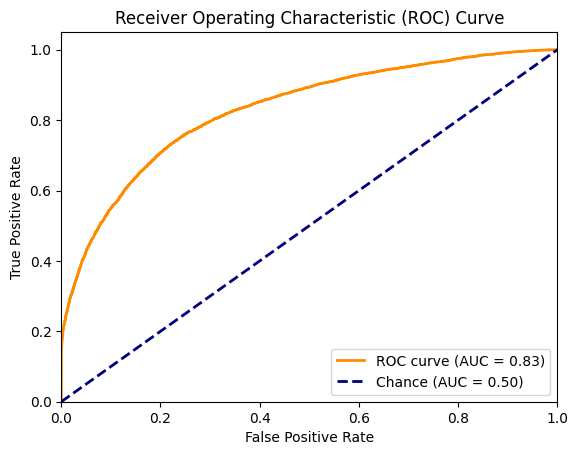


--- Assessing Model Calibration ---


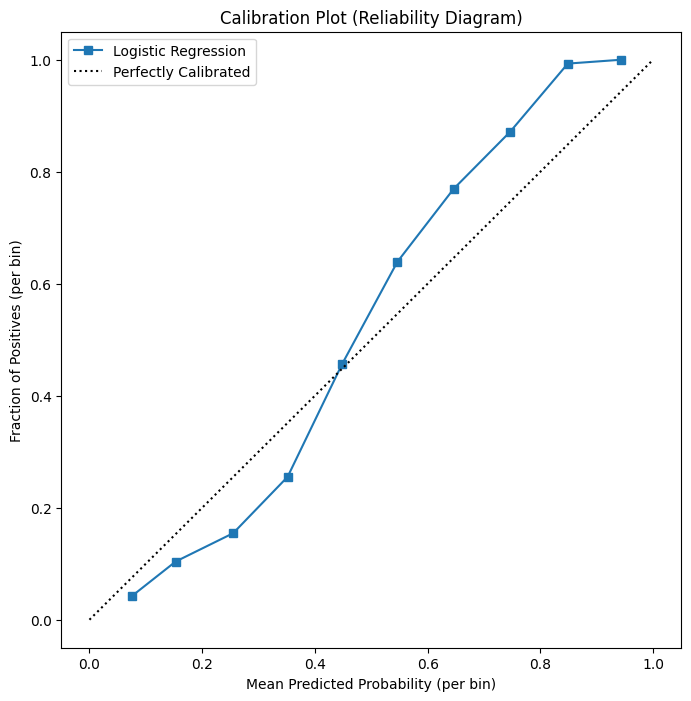

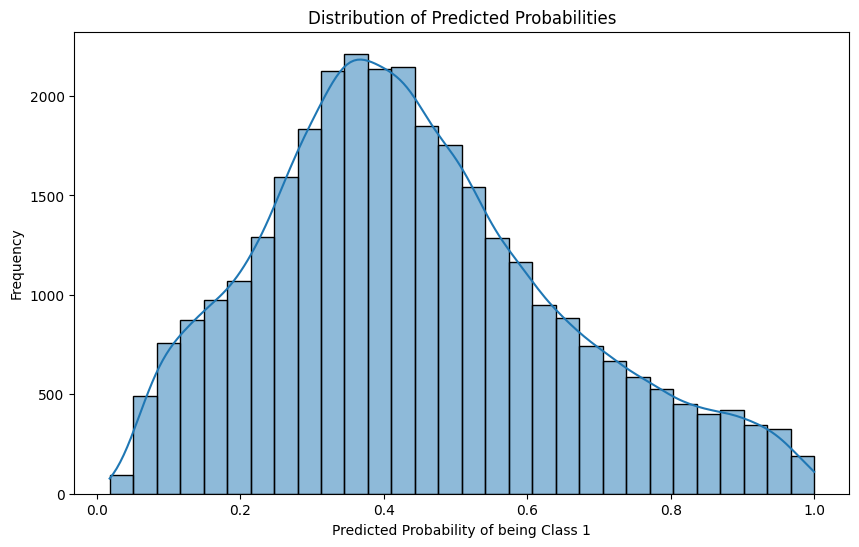

In [10]:
evaluate_model(y_true=football_data_odds['home_win'],y_pred_proba=football_data_odds['cheat'])


--- Performance Metrics on Test Set ---
brier_score_loss: 0.20849071141608824
log_loss: 0.603191910683557
median_calibration_error_metric: 0.01599872771818646
total_calibration_error_metric: 1.8927976796817072
mean_calibration_error_metric: 0.018927976796817073
Accuracy: 0.6626

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.71      0.67      0.69     17740
     Class 1       0.61      0.65      0.63     13969

    accuracy                           0.66     31709
   macro avg       0.66      0.66      0.66     31709
weighted avg       0.67      0.66      0.66     31709



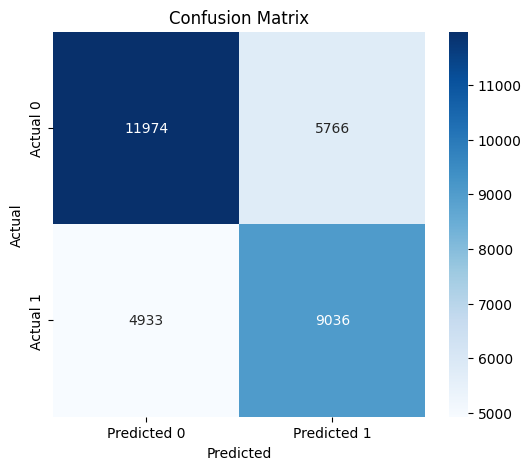

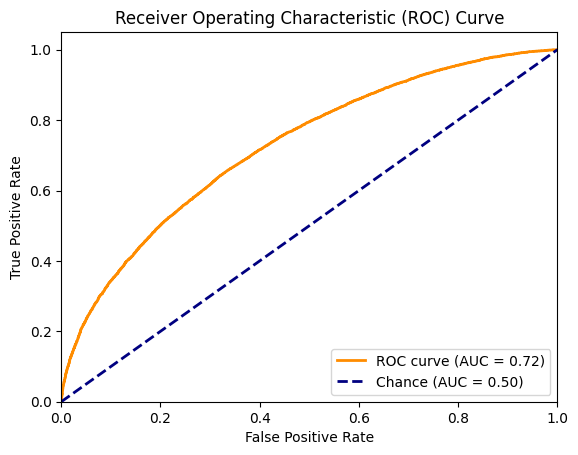


--- Assessing Model Calibration ---


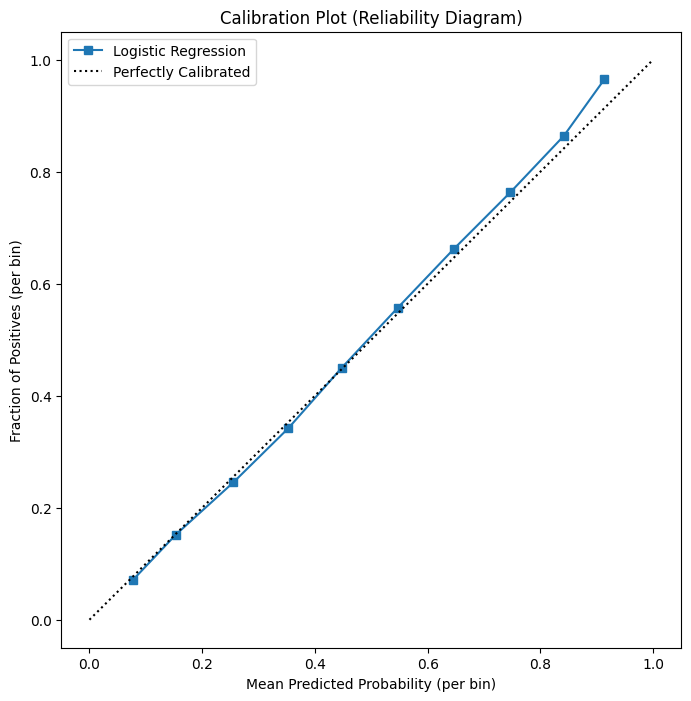

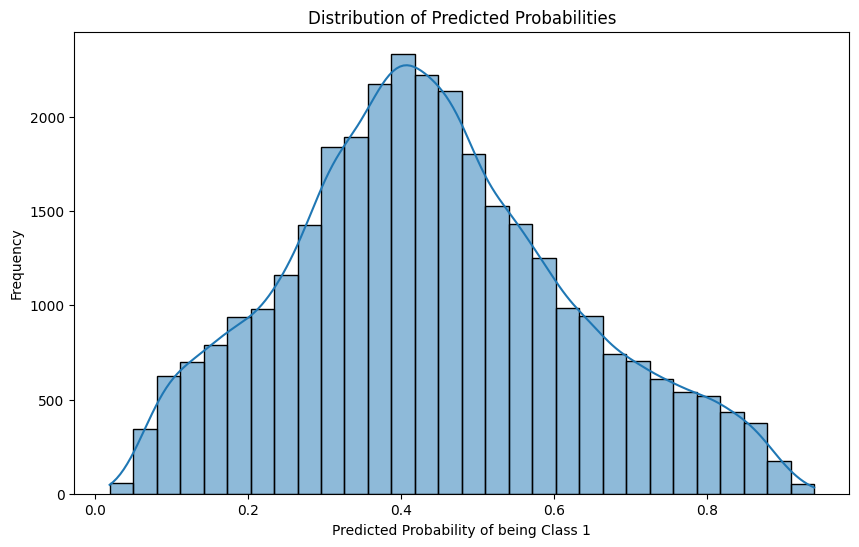

In [11]:
evaluate_model(y_true=football_data_odds['home_win'],y_pred_proba=football_data_odds['PSCH_stripped_prob'])

In [12]:
# football_data_odds[['PSH','PSD','PSA','PS_favorite','PS_favorite_implied_prob','home_win','draw','away_win','PS_favorite_result']]


--- Performance Metrics on Test Set ---
brier_score_loss: 0.22839113922509724
log_loss: 0.6473328021981325
median_calibration_error_metric: 0.01891989321699153
total_calibration_error_metric: 2.175060970800988
mean_calibration_error_metric: 0.021750609708009877
Accuracy: 0.6133

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.57      0.69      0.63     14780
     Class 1       0.67      0.54      0.60     16929

    accuracy                           0.61     31709
   macro avg       0.62      0.62      0.61     31709
weighted avg       0.62      0.61      0.61     31709



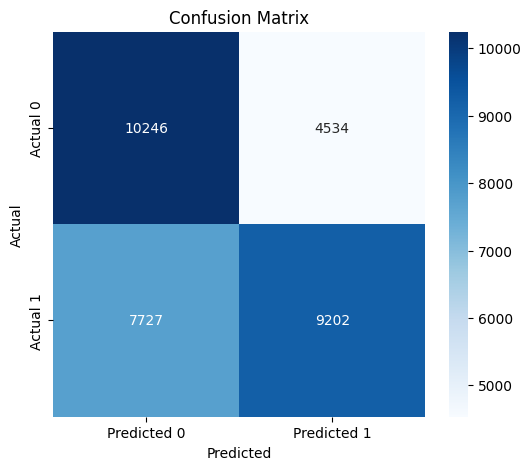

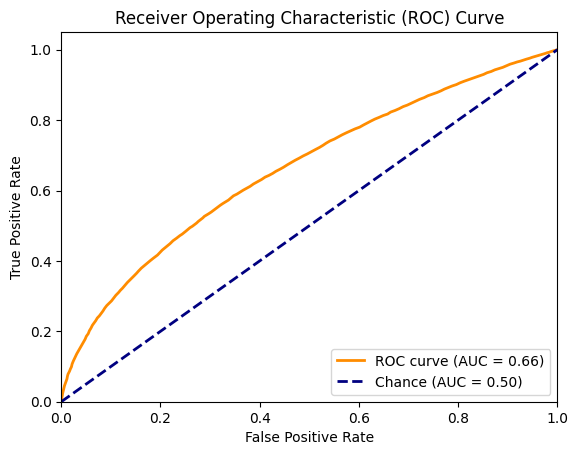


--- Assessing Model Calibration ---


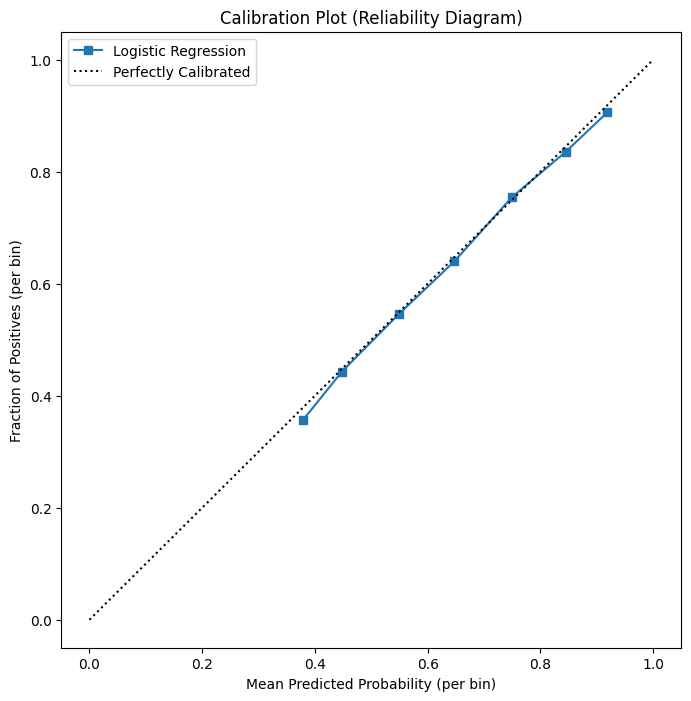

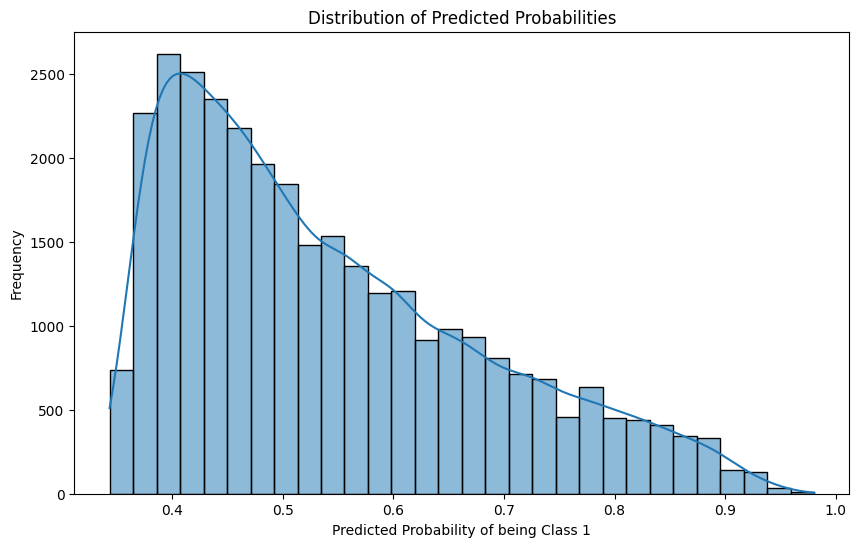

In [13]:
evaluate_model(y_true=football_data_odds['PSC_favorite_result'],y_pred_proba=football_data_odds['PSC_favorite_implied_prob'])


--- Performance Metrics on Test Set ---
brier_score_loss: 0.22942233314470348
log_loss: 0.649647947152301
median_calibration_error_metric: 0.020655217836174827
total_calibration_error_metric: 1.3829152125368525
mean_calibration_error_metric: 0.024694914509586652
Accuracy: 0.6144

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.58      0.67      0.62     14825
     Class 1       0.66      0.57      0.61     16884

    accuracy                           0.61     31709
   macro avg       0.62      0.62      0.61     31709
weighted avg       0.62      0.61      0.61     31709



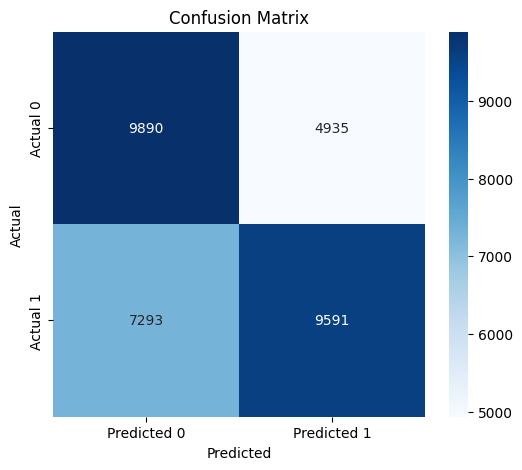

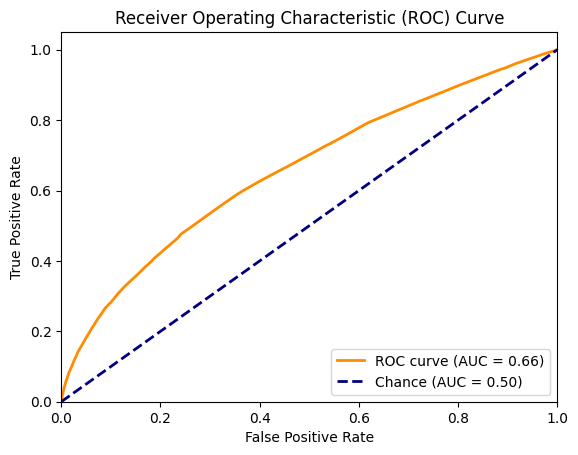


--- Assessing Model Calibration ---


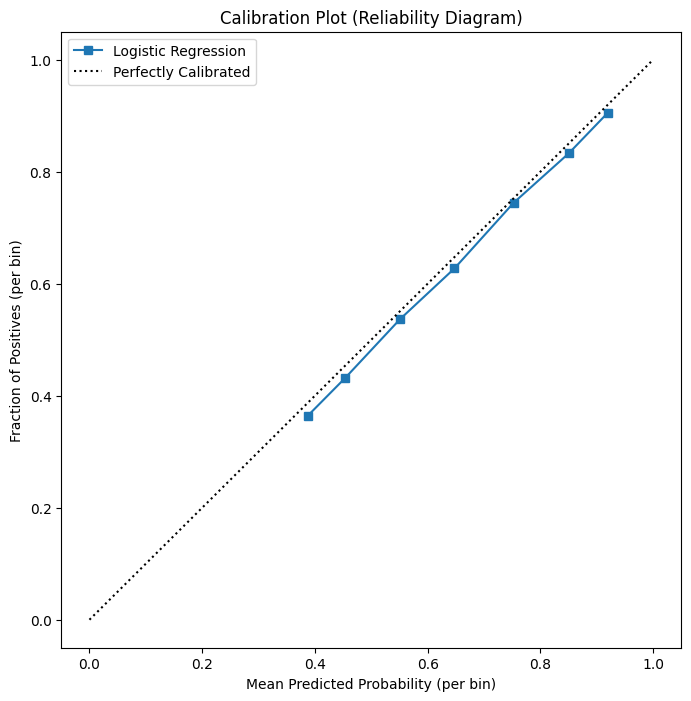

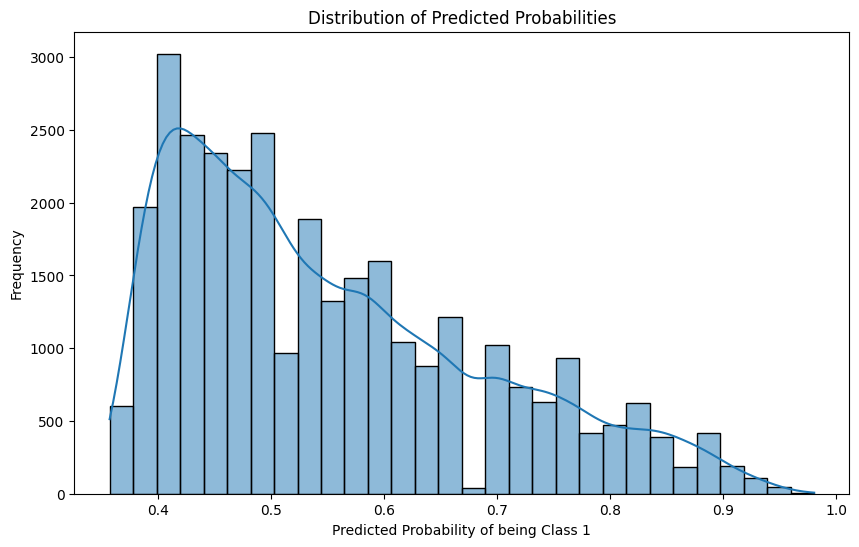

In [14]:
evaluate_model(y_true=football_data_odds['B365_favorite_result'],y_pred_proba=football_data_odds['B365_favorite_implied_prob'])


--- Performance Metrics on Test Set ---
brier_score_loss: 0.16060715107443319
log_loss: 0.4952450411235166
median_calibration_error_metric: 0.018082234001842133
total_calibration_error_metric: 0.7961156709120941
mean_calibration_error_metric: 0.02095041239242353
Accuracy: 0.5025

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.88      0.43      0.58     24994
     Class 1       0.27      0.78      0.40      6715

    accuracy                           0.50     31709
   macro avg       0.57      0.60      0.49     31709
weighted avg       0.75      0.50      0.54     31709



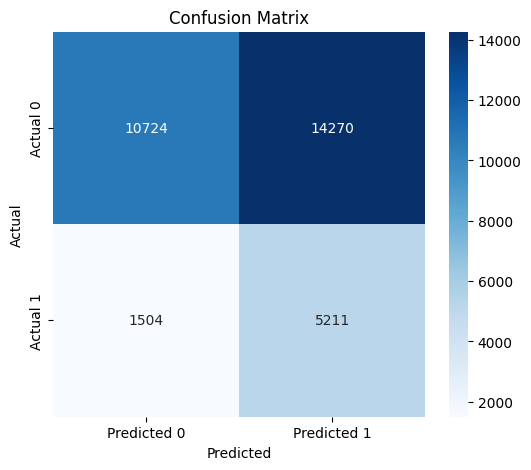

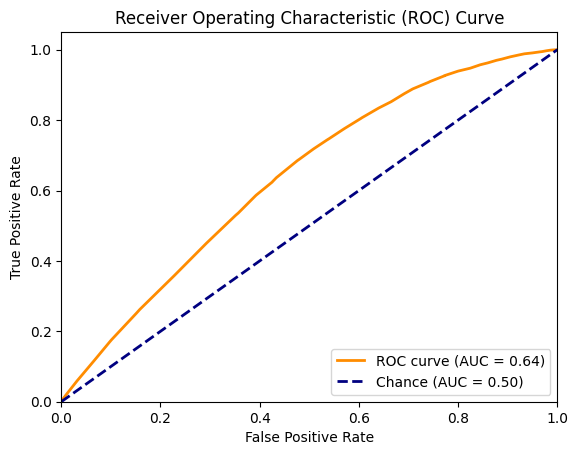


--- Assessing Model Calibration ---


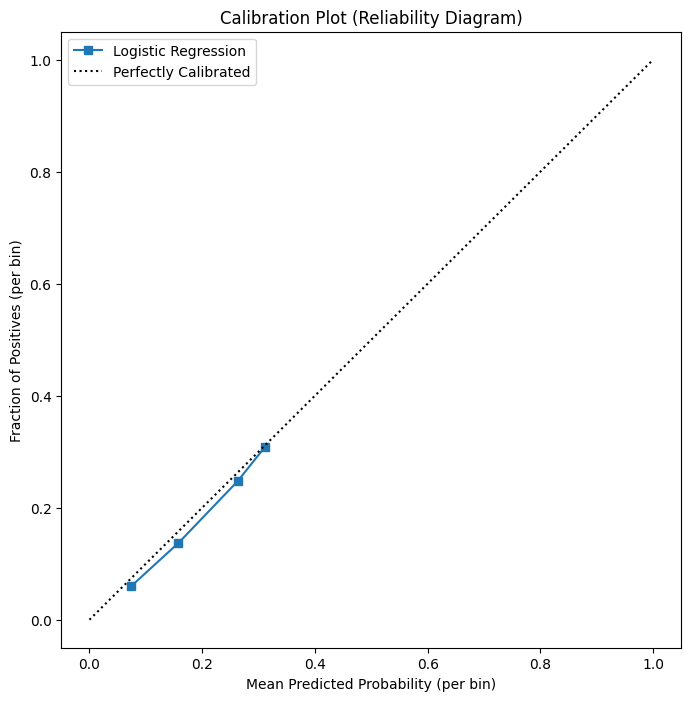

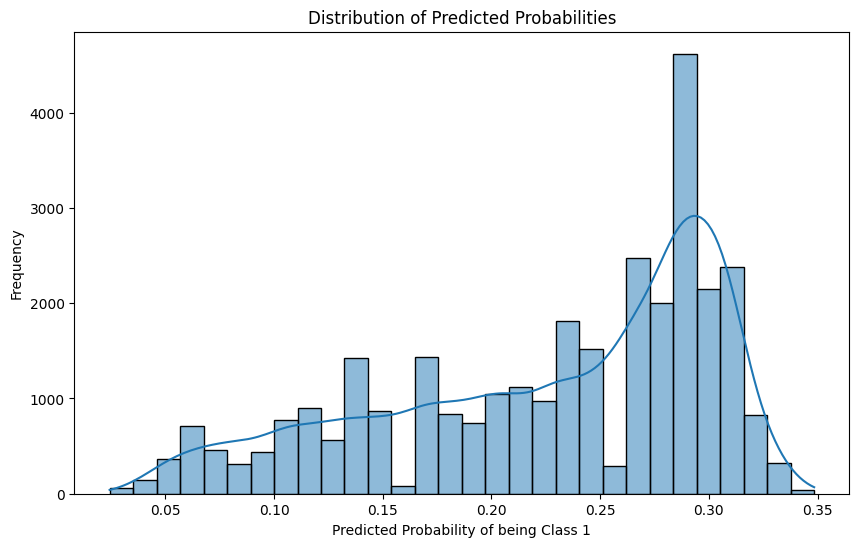

In [15]:
evaluate_model(y_true=football_data_odds['B365_underdog_result'],y_pred_proba=football_data_odds['B365_underdog_implied_prob'])

In [16]:
def calculate_kelly_from_odds(
    model_probs: float,
    bookmaker_implied_probs: float,
    kelly_fraction: float = 0.15
) -> float:
    """
    Calculates the optimal fraction of a bankroll to bet using the Fractional Kelly
    Criterion, based on a model's probs versus bookmaker odds.

    Args:
        model_probs (float): Your model's estimated probs of the event
                                   occurring (must be between 0 and 1).
        bookmaker_odds (float): The decimal odds offered by the bookmaker.
                                Must be greater than 1.0.
        fraction (float, optional): The fraction of the full Kelly bet to use.
                                    Defaults to 1.0 (full Kelly).
                                    Common values are 0.5 (half-Kelly) or 0.25.

    Returns:
        float: The calculated fraction of the bankroll to bet.
               Returns 0.0 if the bet has no positive expected value.
    """

    W = model_probs
    R = (1/bookmaker_implied_probs) - 1

    full_kelly_percentage = W - ((1 - W) / R)
    
    # Apply the fraction to the full Kelly percentage
    fractional_kelly_percentage = kelly_fraction * full_kelly_percentage

    fractional_kelly_percentage = np.where(model_probs > bookmaker_implied_probs,fractional_kelly_percentage,0)

    
    # Ensure we don't return a negative value in rare edge cases
    return fractional_kelly_percentage

football_data_odds['favorite_fractional_kelly_percentage'] = calculate_kelly_from_odds(football_data_odds['PS_favorite_stripped_prob'],football_data_odds['B365_favorite_implied_prob'])
football_data_odds['underdog_fractional_kelly_percentage'] = calculate_kelly_from_odds(football_data_odds['PS_underdog_stripped_prob'],football_data_odds['B365_underdog_implied_prob'])


In [ ]:
def calculate_betting_multipliers(df, model_probs_column_name, selection_column_name, odds_book_name, result_column_name):

    df_copy = df.copy()
    selection = df_copy[selection_column_name]

    bookmaker_implied_probs = np.where(
        selection==0,df_copy[f'{odds_book_name}H_implied_prob'],
        np.where(selection==1,df_copy[f'{odds_book_name}D_implied_prob'],df_copy[f'{odds_book_name}A'])
        )
    
    model_probs = df_copy[model_probs_column_name]
    
    fractional_kelly_percentage = calculate_kelly_from_odds(
        model_probs=model_probs,
        bookmaker_implied_probs=bookmaker_implied_probs
        )
    
    odds = 1/bookmaker_implied_probs
    result = df_copy[result_column_name]

    bankroll_multiplier = np.where(
        selection != result,(1-fractional_kelly_percentage),
        (fractional_kelly_percentage)*(odds) + 1
        )
    
    strategy_name = model_probs_column_name.split('_')[0] + '_' +  model_probs_column_name.split('_')[1]

    df_copy[f'{strategy_name}_strat_fractional_kelly_percentage']=fractional_kelly_percentage
    df_copy[f'{strategy_name}_strat_bankroll_multiplier']=bankroll_multiplier

    return df_copy
    
football_data_odds = calculate_betting_multipliers(
    df=football_data_odds,
    model_probs_column_name='PS_favorite_stripped_prob',
    selection_column_name='PS_favorite_selection',
    odds_book_name='B365',
    result_column_name='result'
)

football_data_odds = calculate_betting_multipliers(
    df=football_data_odds,
    model_probs_column_name='PS_underdog_stripped_prob',
    selection_column_name='PS_underdog_selection',
    odds_book_name='B365',
    result_column_name='result'
)


football_data_odds[['PSH','PSD','PSA','PS_favorite_selection','result','PS_strat_fractional_kelly_percentage','bankroll_multiplier']]

KeyError: "['fractional_kelly_percentage', 'bankroll_multiplier'] not in index"

In [ ]:
one_game_per_day = football_data_odds.sort_values('fractional_kelly_percentage',ascending=False).drop_duplicates(subset='Date_formatted').sort_values('Date_formatted')
one_game_per_day[['PSH','B365H','PSD','B365D','PSA','B365A','PS_favorite_selection','result','fractional_kelly_percentage','bankroll_multiplier']]

In [ ]:
one_game_per_day_since_2024 = one_game_per_day[one_game_per_day['Date_formatted']>pd.to_datetime('2024-08-01')]
np.cumprod(one_game_per_day_since_2024['bankroll_multiplier']).iloc[-1]